In [1]:
import os, sys

def get_root_path(search_word):
    """ Búsqueda hacia atrás de un directorio con nombre search_word. """
    cwd = os.getcwd()
    while str(os.getcwd()).split('/')[-1] != search_word:
        os.chdir("..")
        cwd = os.getcwd()
    return cwd

ROOT_DIR = get_root_path('TFM_StockForecast')

sys.path.insert(0, ROOT_DIR) # Poner en el primer lugar del PATH (evitar paquetes con mismos nombres en otros directorios)

In [2]:
import pandas as pd
import numpy as np
from src.load_data import load_data
from src.prepare_data import prepare_train_data, split_data
from src.trainer import data_producto, run
import matplotlib.pyplot as plt
import seaborn as sns
from keras.wrappers.scikit_learn import KerasRegressor
from src.keras_utils import create_basic_ann

Using TensorFlow backend.
/home/plombao/miniconda3/envs/ds_all/lib/python3.7/site-packages/keras/callbacks/callbacks.py:19: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


In [3]:
import pandas as pd
import os, sys
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

# Modelos
from sklearn.linear_model import LinearRegression ,Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from keras.wrappers.scikit_learn import KerasRegressor

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_box(df, numerical, categorical, ylabel, xlabel):
    df = df[[numerical,categorical]].dropna()
    plt.figure(figsize=(20,15))
    ax = sns.boxplot(x=categorical, y=numerical, data=df)
    ax = sns.swarmplot(x=categorical, y=numerical, data=df, color=".2", alpha=0.3)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    for i, cat in enumerate(df[categorical].unique()):
        data = df.loc[df[categorical] == cat, numerical]
        data.dropna()
        for quan in [0.25, 0.5, 0.75]:
            ax.text(x=i+0.41, y=data.quantile(quan)-0.05, s = '{}'.format(round(data.quantile(quan),2)))

In [5]:
from random import shuffle
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

def k_fold_cross_validation(items, k, randomize=False):
    """"
    A partir de un indice devuelve indices para CV
    """
    if randomize:
        items = list(items)
        shuffle(items)

    slices = [items[i::k] for i in range(k)]

    for i in range(k):
        validation = slices[i]
        training = [item
                    for s in slices if s is not validation
                    for item in s]
        yield training, validation


def split_data_by_index(df, train_idx, test_idx, target):
    """
    A partir de un df divide obtiene las matrices numpy
    X_train, X_test, y_train, y_test segun unos indices y
    una variable target
    """
    # Preparamos los datos de entrada en los modelos
    df_train, df_test = df.iloc[train_idx], df.iloc[test_idx]

    # Convertimos features y target en numpies
    X_train = np.array(df_train.drop(columns=[target], axis=1))
    X_test = np.array(df_test.drop(columns=[target], axis=1))
    y_train = np.array(df_train[target])
    y_test = np.array(df_test[target])

    return X_train, X_test, y_train, y_test


def get_error(y_real, y_pred):
    """
    Devuelve MAE, RMSE y R2 a partir del valor real y el predicho

    """

    mae = mean_absolute_error(y_real, y_pred)
    rmse = np.sqrt(mean_squared_error(y_real, y_pred))
    r2 = r2_score(y_real, y_pred)
    mape = np.mean(np.abs(y_real - y_pred) / y_real) * 100
    acc = max(0, 100 - mape)

    return [mae, rmse, mape, acc]

def inv_transform(y_scaler, y):

    return y_scaler.inverse_transform(y.reshape(-1,1)).reshape(-1)

def fit_model(model, X_train, y_train, X_test, y_test):
    """
    Fita un modelo de regresion a partir de unos datos:
    """
    #Transformamos la variable target a 0-1
    y_scaler = MinMaxScaler()
    y_train = y_scaler.fit_transform(y_train.reshape(-1, 1))

    # Entrenamos
    model.fit(X_train, y_train)

    #Predecimos
    y_pred_train = model.predict(X_train)
    y_pred = model.predict(X_test)

    # Calculamos los errores trasnformando de vuelta los scalers
    err_train = get_error(inv_transform(y_scaler, y_train), inv_transform(y_scaler, y_pred_train))
    err_test = get_error(y_test,  inv_transform(y_scaler, y_pred))

    return model, y_pred, err_train, err_test

In [6]:
def compare_models_cv(df, models, target, scaler, k=10, discretized_df = None):
    """
    Compara modelos de regresion por Cross Validation

    Devuelve un dataframe con los resultados MAE, RMSE y R2 por modelo y set (train/test)
    """

    # Creamos la lista de items para poder seleccionar del indice
    items = [i for i in range(df.shape[0])]

    results = []


    for train_idx, test_idx in k_fold_cross_validation(items, k=k, randomize=True):

        X_train, X_test, y_train, y_test = split_data_by_index(df, train_idx, test_idx, target)

        for name, model in models:
            pipeline = Pipeline(steps=[scaler, model])

            # FITAMOS
            _, _, err_train, err_test = fit_model(pipeline, X_train, y_train, X_test, y_test)

            # CARGAMOS RESULTADOS
            results.append([name, "train"] + err_train)
            results.append([name, "test"] + err_test)

    return pd.DataFrame(data=results, columns=['Model', 'Set', 'MAE', 'RMSE', 'MAPE',"ACC"])

In [7]:
# SCALER
scaler = ('scaler', MinMaxScaler())

# MODELOS
models = [
          ('LR', ('LR',LinearRegression())),
          ('Ridge', ('RDG', Ridge(normalize=True))),
          ('Lasso', ('LSS', Lasso())),
          ('ElasticNet',('EN', ElasticNet())),
          ('KNN', ('KNN', KNeighborsRegressor(n_neighbors=7))),
          ('GBM', ('GBM', GradientBoostingRegressor())),
          ('RF', ('RF', RandomForestRegressor(n_estimators=200))),
          ('SVC', ('SVC', SVR())),
          ('SCV-linear', ("SVC-linear", SVR(kernel='linear'))),
          ('ANN' , ('ANN', KerasRegressor(build_fn=create_basic_ann,verbose=0)))
         ]

# Carga de datos

In [8]:
main_df = load_data()

full_data = pd.DataFrame({})
for prod in main_df.producto.unique():
    data = main_df.loc[main_df.stockMissingType == 0].reset_index(drop=True)
    data = data.loc[data.producto == prod]
    data = prepare_train_data(data)
    data = data[['udsstock', 'roll4wd_udsprevisionempresa',
                                            'working_day', 'month', "quarter","weekofyear",
                                           'summer', 'autumn', 'winter',"cos_weekday","sin_weekday",
                                           'udsprevisionempresa_shifted-1','udsprevisionempresa_shifted-6',
                                            'udsstock_shifted7', 'roll4wd_udsstock_shifted7', 'roll4wd_udsstock'
                                           ]]
    train, test = train_test_split(data, test_size=0.1, shuffle=False)
    full_data = pd.concat([full_data, train]).reset_index(drop=True)
    


===================  LOAD DATASET stock ====================
Reading CSV in data/raw/03_TablaStock.csv...
=============  CLEAN CSV  ==============
Set columns to lowcase.
Sort values by date.
Dropped duplicates. Rows dropped: 628.
============  CLEAN STOCK  =============
Dropped rows with data from products with no stock data or out-of-date (descatalogados). Rows dropped: 1764
[WARNING] Number of dates missings:                                83
[WARNING] Number of dates missings (droping sundays and festivos): 63
[WARNING] Stock data with different units for same product & data. Rows: 12679
Dataset stock loaded. Shape: (25538, 3)

===================  LOAD DATASET ventas ===================
Reading CSV in data/raw/01_TablaVentas.csv...
=============  CLEAN CSV  ==============
Set columns to lowcase.
Sort values by date.
Dropped duplicates. Rows dropped: 0.
============  CLEAN VENTAS  ============
Dropped rows with data from products with no stock data or out-of-date (descatalogados). 

/mnt/c/Users/Administrador/Documents/GitHub/TFM_StockForecast/src/create_variables.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ts['missing'] = (ts.udsstock.isna()) * 1
/mnt/c/Users/Administrador/Documents/GitHub/TFM_StockForecast/src/create_variables.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  day_data["roll4wd_" + col] = day_data.loc[(day_data.festivo == 0), col].rolling(4, win_type='triang', min_periods=1).mean()
/mnt/c/Users/Administrador/Documents/GitHub/TFM_StockForecast/src/create_va

Get stock missing type
Getting rolling windows of last 5 days by product and weekday for column udsventa
Getting rolling windows of last 5 days by product and weekday for column udsstock
Getting rolling windows of last 5 days by product and weekday for column udsprevisionempresa
Getting rolling windows of last 5 days by product and weekday for column udsventa
Getting rolling windows of last 5 days by product and weekday for column udsstock
Getting rolling windows of last 5 days by product and weekday for column udsprevisionempresa
Getting rolling windows of last 5 days by product and weekday for column udsventa
Getting rolling windows of last 5 days by product and weekday for column udsstock
Getting rolling windows of last 5 days by product and weekday for column udsprevisionempresa
Getting rolling windows of last 5 days by product and weekday for column udsventa
Getting rolling windows of last 5 days by product and weekday for column udsstock
Getting rolling windows of last 5 days by 

Getting rolling windows of last 5 days by product and weekday for column udsventa
Getting rolling windows of last 5 days by product and weekday for column udsstock
Getting rolling windows of last 5 days by product and weekday for column udsprevisionempresa
Getting rolling windows of last 5 days by product and weekday for column udsventa
Getting rolling windows of last 5 days by product and weekday for column udsstock
Getting rolling windows of last 5 days by product and weekday for column udsprevisionempresa
Getting rolling windows of last 5 days by product and weekday for column udsventa
Getting rolling windows of last 5 days by product and weekday for column udsstock
Getting rolling windows of last 5 days by product and weekday for column udsprevisionempresa
Getting rolling windows of last 5 days by product and weekday for column udsventa
Getting rolling windows of last 5 days by product and weekday for column udsstock
Getting rolling windows of last 5 days by product and weekday for

Getting rolling windows of last 5 days by product and weekday for column udsventa
Getting rolling windows of last 5 days by product and weekday for column udsstock
Getting rolling windows of last 5 days by product and weekday for column udsprevisionempresa
Getting rolling windows of last 5 days by product and weekday for column udsventa
Getting rolling windows of last 5 days by product and weekday for column udsstock
Getting rolling windows of last 5 days by product and weekday for column udsprevisionempresa
Getting rolling windows of last 5 days by product and weekday for column udsventa
Getting rolling windows of last 5 days by product and weekday for column udsstock
Getting rolling windows of last 5 days by product and weekday for column udsprevisionempresa
Getting rolling windows of last 5 days by product and weekday for column udsventa
Getting rolling windows of last 5 days by product and weekday for column udsstock
Getting rolling windows of last 5 days by product and weekday for

Getting rolling windows of last 5 days by product and weekday for column udsstock
Getting rolling windows of last 5 days by product and weekday for column udsprevisionempresa
Getting rolling windows of last 5 days by product and weekday for column udsventa
Getting rolling windows of last 5 days by product and weekday for column udsstock
Getting rolling windows of last 5 days by product and weekday for column udsprevisionempresa
Get stock missing type
Getting rolling windows of last 5 days by product and weekday for column udsventa
Getting rolling windows of last 5 days by product and weekday for column udsstock
Getting rolling windows of last 5 days by product and weekday for column udsprevisionempresa
Getting rolling windows of last 5 days by product and weekday for column udsventa
Getting rolling windows of last 5 days by product and weekday for column udsstock
Getting rolling windows of last 5 days by product and weekday for column udsprevisionempresa
Getting rolling windows of last

Get stock missing type
Getting rolling windows of last 5 days by product and weekday for column udsventa
Getting rolling windows of last 5 days by product and weekday for column udsstock
Getting rolling windows of last 5 days by product and weekday for column udsprevisionempresa
Getting rolling windows of last 5 days by product and weekday for column udsventa
Getting rolling windows of last 5 days by product and weekday for column udsstock
Getting rolling windows of last 5 days by product and weekday for column udsprevisionempresa
Getting rolling windows of last 5 days by product and weekday for column udsventa
Getting rolling windows of last 5 days by product and weekday for column udsstock
Getting rolling windows of last 5 days by product and weekday for column udsprevisionempresa
Getting rolling windows of last 5 days by product and weekday for column udsventa
Getting rolling windows of last 5 days by product and weekday for column udsstock
Getting rolling windows of last 5 days by 

Getting rolling windows of last 5 days by product and weekday for column udsprevisionempresa
Getting rolling windows of last 5 days by product and weekday for column udsventa
Getting rolling windows of last 5 days by product and weekday for column udsstock
Getting rolling windows of last 5 days by product and weekday for column udsprevisionempresa
Getting rolling windows of last 5 days by product and weekday for column udsventa
Getting rolling windows of last 5 days by product and weekday for column udsstock
Getting rolling windows of last 5 days by product and weekday for column udsprevisionempresa
Getting rolling windows of last 5 days by product and weekday for column udsventa
Getting rolling windows of last 5 days by product and weekday for column udsstock
Getting rolling windows of last 5 days by product and weekday for column udsprevisionempresa
Getting rolling windows of last 5 days by product and weekday for column udsventa
Getting rolling windows of last 5 days by product and 

Get stock missing type
Getting rolling windows of last 5 days by product and weekday for column udsventa
Getting rolling windows of last 5 days by product and weekday for column udsstock
Getting rolling windows of last 5 days by product and weekday for column udsprevisionempresa
Getting rolling windows of last 5 days by product and weekday for column udsventa
Getting rolling windows of last 5 days by product and weekday for column udsstock
Getting rolling windows of last 5 days by product and weekday for column udsprevisionempresa
Getting rolling windows of last 5 days by product and weekday for column udsventa
Getting rolling windows of last 5 days by product and weekday for column udsstock
Getting rolling windows of last 5 days by product and weekday for column udsprevisionempresa
Getting rolling windows of last 5 days by product and weekday for column udsventa
Getting rolling windows of last 5 days by product and weekday for column udsstock
Getting rolling windows of last 5 days by 

Getting rolling windows of last 5 days by product and weekday for column udsprevisionempresa
Getting rolling windows of last 5 days by product and weekday for column udsventa
Getting rolling windows of last 5 days by product and weekday for column udsstock
Getting rolling windows of last 5 days by product and weekday for column udsprevisionempresa
Getting rolling windows of last 5 days by product and weekday for column udsventa
Getting rolling windows of last 5 days by product and weekday for column udsstock
Getting rolling windows of last 5 days by product and weekday for column udsprevisionempresa
Get stock missing type
Getting rolling windows of last 5 days by product and weekday for column udsventa
Getting rolling windows of last 5 days by product and weekday for column udsstock
Getting rolling windows of last 5 days by product and weekday for column udsprevisionempresa
Getting rolling windows of last 5 days by product and weekday for column udsventa
Getting rolling windows of last

Getting rolling windows of last 5 days by product and weekday for column udsprevisionempresa
Get stock missing type
Getting rolling windows of last 5 days by product and weekday for column udsventa
Getting rolling windows of last 5 days by product and weekday for column udsstock
Getting rolling windows of last 5 days by product and weekday for column udsprevisionempresa
Getting rolling windows of last 5 days by product and weekday for column udsventa
Getting rolling windows of last 5 days by product and weekday for column udsstock
Getting rolling windows of last 5 days by product and weekday for column udsprevisionempresa
Getting rolling windows of last 5 days by product and weekday for column udsventa
Getting rolling windows of last 5 days by product and weekday for column udsstock
Getting rolling windows of last 5 days by product and weekday for column udsprevisionempresa
Getting rolling windows of last 5 days by product and weekday for column udsventa
Getting rolling windows of last

Getting rolling windows of last 5 days by product and weekday for column udsventa
Getting rolling windows of last 5 days by product and weekday for column udsstock
Getting rolling windows of last 5 days by product and weekday for column udsprevisionempresa
Getting rolling windows of last 5 days by product and weekday for column udsventa
Getting rolling windows of last 5 days by product and weekday for column udsstock
Getting rolling windows of last 5 days by product and weekday for column udsprevisionempresa
Getting rolling windows of last 5 days by product and weekday for column udsventa
Getting rolling windows of last 5 days by product and weekday for column udsstock
Getting rolling windows of last 5 days by product and weekday for column udsprevisionempresa
Getting rolling windows of last 5 days by product and weekday for column udsventa
Getting rolling windows of last 5 days by product and weekday for column udsstock
Getting rolling windows of last 5 days by product and weekday for

Get stock missing type
Getting rolling windows of last 5 days by product and weekday for column udsventa
Getting rolling windows of last 5 days by product and weekday for column udsstock
Getting rolling windows of last 5 days by product and weekday for column udsprevisionempresa
Getting rolling windows of last 5 days by product and weekday for column udsventa
Getting rolling windows of last 5 days by product and weekday for column udsstock
Getting rolling windows of last 5 days by product and weekday for column udsprevisionempresa
Getting rolling windows of last 5 days by product and weekday for column udsventa
Getting rolling windows of last 5 days by product and weekday for column udsstock
Getting rolling windows of last 5 days by product and weekday for column udsprevisionempresa
Getting rolling windows of last 5 days by product and weekday for column udsventa
Getting rolling windows of last 5 days by product and weekday for column udsstock
Getting rolling windows of last 5 days by 

Getting rolling windows of last 5 days by product and weekday for column udsventa
Getting rolling windows of last 5 days by product and weekday for column udsstock
Getting rolling windows of last 5 days by product and weekday for column udsprevisionempresa
Get stock missing type
Getting rolling windows of last 5 days by product and weekday for column udsventa
Getting rolling windows of last 5 days by product and weekday for column udsstock
Getting rolling windows of last 5 days by product and weekday for column udsprevisionempresa
Getting rolling windows of last 5 days by product and weekday for column udsventa
Getting rolling windows of last 5 days by product and weekday for column udsstock
Getting rolling windows of last 5 days by product and weekday for column udsprevisionempresa
Getting rolling windows of last 5 days by product and weekday for column udsventa
Getting rolling windows of last 5 days by product and weekday for column udsstock
Getting rolling windows of last 5 days by 

Get stock missing type
Getting rolling windows of last 5 days by product and weekday for column udsventa
Getting rolling windows of last 5 days by product and weekday for column udsstock
Getting rolling windows of last 5 days by product and weekday for column udsprevisionempresa
Getting rolling windows of last 5 days by product and weekday for column udsventa
Getting rolling windows of last 5 days by product and weekday for column udsstock
Getting rolling windows of last 5 days by product and weekday for column udsprevisionempresa
Getting rolling windows of last 5 days by product and weekday for column udsventa
Getting rolling windows of last 5 days by product and weekday for column udsstock
Getting rolling windows of last 5 days by product and weekday for column udsprevisionempresa
Getting rolling windows of last 5 days by product and weekday for column udsventa
Getting rolling windows of last 5 days by product and weekday for column udsstock
Getting rolling windows of last 5 days by 

Get shifted variable for udsprevisionempresa with period -2
Get shifted variable for udsprevisionempresa with period -3
Get shifted variable for udsprevisionempresa with period -4
Get shifted variable for udsprevisionempresa with period -5
Get shifted variable for udsprevisionempresa with period -6
Get shifted variable for udsprevisionempresa with period -7
Get diff variable for udsstock with period -1
Get diff variable for udsstock with period 1
Get diff variable for udsstock with period 7
Get diff variable for udsventa with period 1
Get shifted variable for udsstock with period -1
Get shifted variable for udsstock with period 1
Get shifted variable for udsstock with period 7
Get shifted variable for roll4wd_udsstock with period 1
Get shifted variable for roll4wd_udsstock with period 7
Get shifted variable for udsventa with period 1
Output shape: (183, 44)
===================  FILTER TRAIN DATA  ====================
Dropped rows corresponding to 23 to 26-03-2020 for not having the ven

===================  FILTER TRAIN DATA  ====================
Dropped rows corresponding to 23 to 26-03-2020 for not having the ventas data for these days.
Rows dropped: 4
Assigned missings in udsventa.
Assigned missings in udsprevisionempresa filling with 0
Assigning missings for udsstock
Missing in dataset:               0 (197 total rows).
Missings in holiday days:         0 (29 total rows).
Missings in working days:         0 (168 total rows).
Assigned missings for working days data with the 4last wd rolling window - Remaining missings: 0
Assigned left missings for working days data with the mean of the weekday - Remaining missings: 0
Assigned missings for holiday data and no active business data - Remaining missings:      0
Get shifted variable for udsprevisionempresa with period -1
Get shifted variable for udsprevisionempresa with period -2
Get shifted variable for udsprevisionempresa with period -3
Get shifted variable for udsprevisionempresa with period -4
Get shifted variable f

Get shifted variable for udsprevisionempresa with period -7
Get diff variable for udsstock with period -1
Get diff variable for udsstock with period 1
Get diff variable for udsstock with period 7
Get diff variable for udsventa with period 1
Get shifted variable for udsstock with period -1
Get shifted variable for udsstock with period 1
Get shifted variable for udsstock with period 7
Get shifted variable for roll4wd_udsstock with period 1
Get shifted variable for roll4wd_udsstock with period 7
Get shifted variable for udsventa with period 1
Output shape: (182, 44)
===================  FILTER TRAIN DATA  ====================
Dropped rows corresponding to 23 to 26-03-2020 for not having the ventas data for these days.
Rows dropped: 4
Assigned missings in udsventa.
Assigned missings in udsprevisionempresa filling with 0
Assigning missings for udsstock
Missing in dataset:               0 (203 total rows).
Missings in holiday days:         0 (30 total rows).
Missings in working days:        

Assigned missings for working days data with the 4last wd rolling window - Remaining missings: 0
Assigned left missings for working days data with the mean of the weekday - Remaining missings: 0
Assigned missings for holiday data and no active business data - Remaining missings:      0
Get shifted variable for udsprevisionempresa with period -1
Get shifted variable for udsprevisionempresa with period -2
Get shifted variable for udsprevisionempresa with period -3
Get shifted variable for udsprevisionempresa with period -4
Get shifted variable for udsprevisionempresa with period -5
Get shifted variable for udsprevisionempresa with period -6
Get shifted variable for udsprevisionempresa with period -7
Get diff variable for udsstock with period -1
Get diff variable for udsstock with period 1
Get diff variable for udsstock with period 7
Get diff variable for udsventa with period 1
Get shifted variable for udsstock with period -1
Get shifted variable for udsstock with period 1
Get shifted var

Get shifted variable for udsprevisionempresa with period -4
Get shifted variable for udsprevisionempresa with period -5
Get shifted variable for udsprevisionempresa with period -6
Get shifted variable for udsprevisionempresa with period -7
Get diff variable for udsstock with period -1
Get diff variable for udsstock with period 1
Get diff variable for udsstock with period 7
Get diff variable for udsventa with period 1
Get shifted variable for udsstock with period -1
Get shifted variable for udsstock with period 1
Get shifted variable for udsstock with period 7
Get shifted variable for roll4wd_udsstock with period 1
Get shifted variable for roll4wd_udsstock with period 7
Get shifted variable for udsventa with period 1
Output shape: (196, 44)
===================  FILTER TRAIN DATA  ====================
Dropped rows corresponding to 23 to 26-03-2020 for not having the ventas data for these days.
Rows dropped: 4
Assigned missings in udsventa.
Assigned missings in udsprevisionempresa filling

===================  FILTER TRAIN DATA  ====================
Dropped rows corresponding to 23 to 26-03-2020 for not having the ventas data for these days.
Rows dropped: 4
Assigned missings in udsventa.
Assigned missings in udsprevisionempresa filling with 0
Assigning missings for udsstock
Missing in dataset:               0 (194 total rows).
Missings in holiday days:         0 (27 total rows).
Missings in working days:         0 (167 total rows).
Assigned missings for working days data with the 4last wd rolling window - Remaining missings: 0
Assigned left missings for working days data with the mean of the weekday - Remaining missings: 0
Assigned missings for holiday data and no active business data - Remaining missings:      0
Get shifted variable for udsprevisionempresa with period -1
Get shifted variable for udsprevisionempresa with period -2
Get shifted variable for udsprevisionempresa with period -3
Get shifted variable for udsprevisionempresa with period -4
Get shifted variable f

Get shifted variable for udsstock with period 1
Get shifted variable for udsstock with period 7
Get shifted variable for roll4wd_udsstock with period 1
Get shifted variable for roll4wd_udsstock with period 7
Get shifted variable for udsventa with period 1
Output shape: (199, 44)
===================  FILTER TRAIN DATA  ====================
Dropped rows corresponding to 23 to 26-03-2020 for not having the ventas data for these days.
Rows dropped: 4
Assigned missings in udsventa.
Assigned missings in udsprevisionempresa filling with 0
Assigning missings for udsstock
Missing in dataset:               0 (189 total rows).
Missings in holiday days:         0 (30 total rows).
Missings in working days:         0 (159 total rows).
Assigned missings for working days data with the 4last wd rolling window - Remaining missings: 0
Assigned left missings for working days data with the mean of the weekday - Remaining missings: 0
Assigned missings for holiday data and no active business data - Remaining

Assigned missings for working days data with the 4last wd rolling window - Remaining missings: 0
Assigned left missings for working days data with the mean of the weekday - Remaining missings: 0
Assigned missings for holiday data and no active business data - Remaining missings:      0
Get shifted variable for udsprevisionempresa with period -1
Get shifted variable for udsprevisionempresa with period -2
Get shifted variable for udsprevisionempresa with period -3
Get shifted variable for udsprevisionempresa with period -4
Get shifted variable for udsprevisionempresa with period -5
Get shifted variable for udsprevisionempresa with period -6
Get shifted variable for udsprevisionempresa with period -7
Get diff variable for udsstock with period -1
Get diff variable for udsstock with period 1
Get diff variable for udsstock with period 7
Get diff variable for udsventa with period 1
Get shifted variable for udsstock with period -1
Get shifted variable for udsstock with period 1
Get shifted var

Get shifted variable for udsprevisionempresa with period -2
Get shifted variable for udsprevisionempresa with period -3
Get shifted variable for udsprevisionempresa with period -4
Get shifted variable for udsprevisionempresa with period -5
Get shifted variable for udsprevisionempresa with period -6
Get shifted variable for udsprevisionempresa with period -7
Get diff variable for udsstock with period -1
Get diff variable for udsstock with period 1
Get diff variable for udsstock with period 7
Get diff variable for udsventa with period 1
Get shifted variable for udsstock with period -1
Get shifted variable for udsstock with period 1
Get shifted variable for udsstock with period 7
Get shifted variable for roll4wd_udsstock with period 1
Get shifted variable for roll4wd_udsstock with period 7
Get shifted variable for udsventa with period 1
Output shape: (195, 44)
===================  FILTER TRAIN DATA  ====================
Dropped rows corresponding to 23 to 26-03-2020 for not having the ven

===================  FILTER TRAIN DATA  ====================
Dropped rows corresponding to 23 to 26-03-2020 for not having the ventas data for these days.
Rows dropped: 4
Assigned missings in udsventa.
Assigned missings in udsprevisionempresa filling with 0
Assigning missings for udsstock
Missing in dataset:               0 (207 total rows).
Missings in holiday days:         0 (30 total rows).
Missings in working days:         0 (177 total rows).
Assigned missings for working days data with the 4last wd rolling window - Remaining missings: 0
Assigned left missings for working days data with the mean of the weekday - Remaining missings: 0
Assigned missings for holiday data and no active business data - Remaining missings:      0
Get shifted variable for udsprevisionempresa with period -1
Get shifted variable for udsprevisionempresa with period -2
Get shifted variable for udsprevisionempresa with period -3
Get shifted variable for udsprevisionempresa with period -4
Get shifted variable f

Assigned missings for working days data with the 4last wd rolling window - Remaining missings: 0
Assigned left missings for working days data with the mean of the weekday - Remaining missings: 0
Assigned missings for holiday data and no active business data - Remaining missings:      0
Get shifted variable for udsprevisionempresa with period -1
Get shifted variable for udsprevisionempresa with period -2
Get shifted variable for udsprevisionempresa with period -3
Get shifted variable for udsprevisionempresa with period -4
Get shifted variable for udsprevisionempresa with period -5
Get shifted variable for udsprevisionempresa with period -6
Get shifted variable for udsprevisionempresa with period -7
Get diff variable for udsstock with period -1
Get diff variable for udsstock with period 1
Get diff variable for udsstock with period 7
Get diff variable for udsventa with period 1
Get shifted variable for udsstock with period -1
Get shifted variable for udsstock with period 1
Get shifted var

Get shifted variable for udsstock with period 7
Get shifted variable for roll4wd_udsstock with period 1
Get shifted variable for roll4wd_udsstock with period 7
Get shifted variable for udsventa with period 1
Output shape: (198, 44)
===================  FILTER TRAIN DATA  ====================
Dropped rows corresponding to 23 to 26-03-2020 for not having the ventas data for these days.
Rows dropped: 4
Assigned missings in udsventa.
Assigned missings in udsprevisionempresa filling with 0
Assigning missings for udsstock
Missing in dataset:               0 (191 total rows).
Missings in holiday days:         0 (26 total rows).
Missings in working days:         0 (165 total rows).
Assigned missings for working days data with the 4last wd rolling window - Remaining missings: 0
Assigned left missings for working days data with the mean of the weekday - Remaining missings: 0
Assigned missings for holiday data and no active business data - Remaining missings:      0
Get shifted variable for udspr

Output shape: (198, 44)
===================  FILTER TRAIN DATA  ====================
Dropped rows corresponding to 23 to 26-03-2020 for not having the ventas data for these days.
Rows dropped: 4
Assigned missings in udsventa.
Assigned missings in udsprevisionempresa filling with 0
Assigning missings for udsstock
Missing in dataset:               0 (202 total rows).
Missings in holiday days:         0 (30 total rows).
Missings in working days:         0 (172 total rows).
Assigned missings for working days data with the 4last wd rolling window - Remaining missings: 0
Assigned left missings for working days data with the mean of the weekday - Remaining missings: 0
Assigned missings for holiday data and no active business data - Remaining missings:      0
Get shifted variable for udsprevisionempresa with period -1
Get shifted variable for udsprevisionempresa with period -2
Get shifted variable for udsprevisionempresa with period -3
Get shifted variable for udsprevisionempresa with period -

In [9]:
full_data

,udsstock,roll4wd_udsprevisionempresa,working_day,month,quarter,weekofyear,summer,autumn,winter,cos_weekday,sin_weekday,udsprevisionempresa_shifted-1,udsprevisionempresa_shifted-6,udsstock_shifted7,roll4wd_udsstock_shifted7,roll4wd_udsstock
0,18275.0,102304.000,True,6,2,23,1,0,0,-0.222521,0.974928,13602.0,0.0,0.0,0.000,18275.000
1,2920.0,13602.000,True,6,2,24,1,0,0,0.623490,0.781831,25032.0,12469.0,0.0,0.000,2920.000
2,6731.0,82986.000,True,6,2,24,1,0,0,-0.222521,0.974928,7557.0,13224.0,0.0,0.000,15389.000
3,7241.0,27748.500,True,6,2,24,1,0,0,-0.900969,0.433884,6234.0,71414.0,0.0,0.000,7241.000
4,3850.0,20403.750,True,6,2,24,1,0,0,-0.900969,-0.433884,44722.0,15869.0,0.0,0.000,3850.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11320,415.0,1015.000,True,2,1,7,0,0,1,-0.900969,0.433884,2668.0,1241.0,379.0,400.250,361.875
11321,546.0,1486.500,True,2,1,7,0,0,1,-0.900969,-0.433884,3211.0,1500.0,416.0,392.000,398.750
11322,529.0,1769.250,True,2,1,8,0,0,1,1.000000,0.000000,2076.0,1561.0,405.0,495.200,602.250
11323,505.0,1710.250,True,2,1,8,0,0,1,0.623490,0.781831,2042.0,2255.0,399.0,480.500,423.750


# Modelado

In [10]:
# MODELS

target = "udsstock"

# Definimos o scaler e os modelos
scaler = ('scaler', MinMaxScaler())

# Cogemos los nombres de las variables para usarlos más adelante
features_list = full_data.columns

results = compare_models_cv(train.drop("roll4wd_udsstock",axis=1), models, target, scaler, k=10)

results.head()

/home/plombao/miniconda3/envs/ds_all/lib/python3.7/site-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/plombao/miniconda3/envs/ds_all/lib/python3.7/site-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
/home/plombao/miniconda3/envs/ds_all/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/plombao/miniconda3/envs/ds_all/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vecto

/home/plombao/miniconda3/envs/ds_all/lib/python3.7/site-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/plombao/miniconda3/envs/ds_all/lib/python3.7/site-packages/sklearn/pipeline.py:354: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
/home/plombao/miniconda3/envs/ds_all/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/plombao/miniconda3/envs/ds_all/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vecto

,Model,Set,MAE,RMSE,MAPE,ACC
0,LR,train,140.951070,195.524469,63.574187,36.425813
1,LR,test,220.276082,287.593665,87.452258,12.547742
2,Ridge,train,147.186850,201.127244,63.716272,36.283728
3,Ridge,test,207.339538,270.423798,84.274393,15.725607
4,Lasso,train,151.877915,204.672102,64.137619,35.862381


In [11]:
[mae_base, rmse_base, mape_base, acc_base] = get_error(full_data["udsstock"], full_data["roll4wd_udsstock_shifted7"])

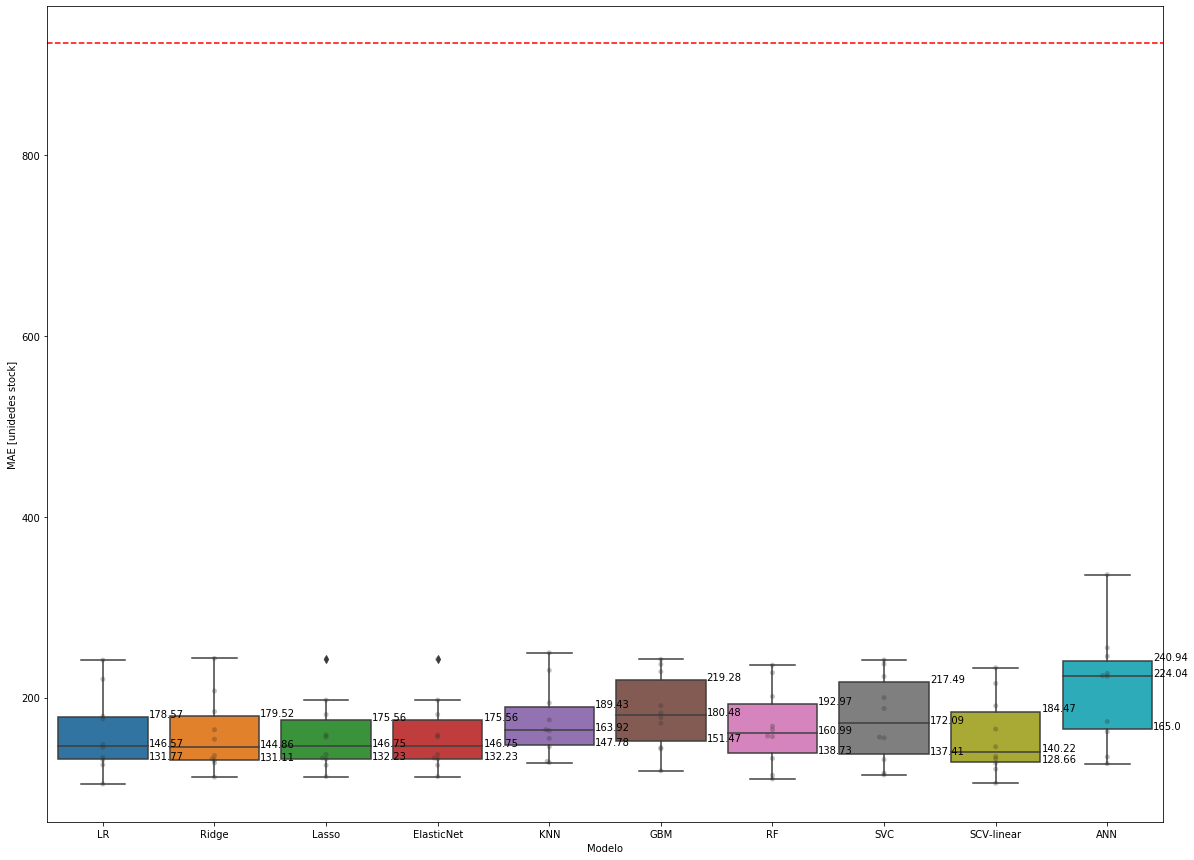

In [12]:
plot_box(results.loc[results.Set == 'test'], 'MAE','Model', 'MAE [unidedes stock]', 'Modelo')

plt.axhline(y= mae_base, color='r', linestyle='--')
plt.savefig("reports/algorithms/mae_all.png".format(prod))

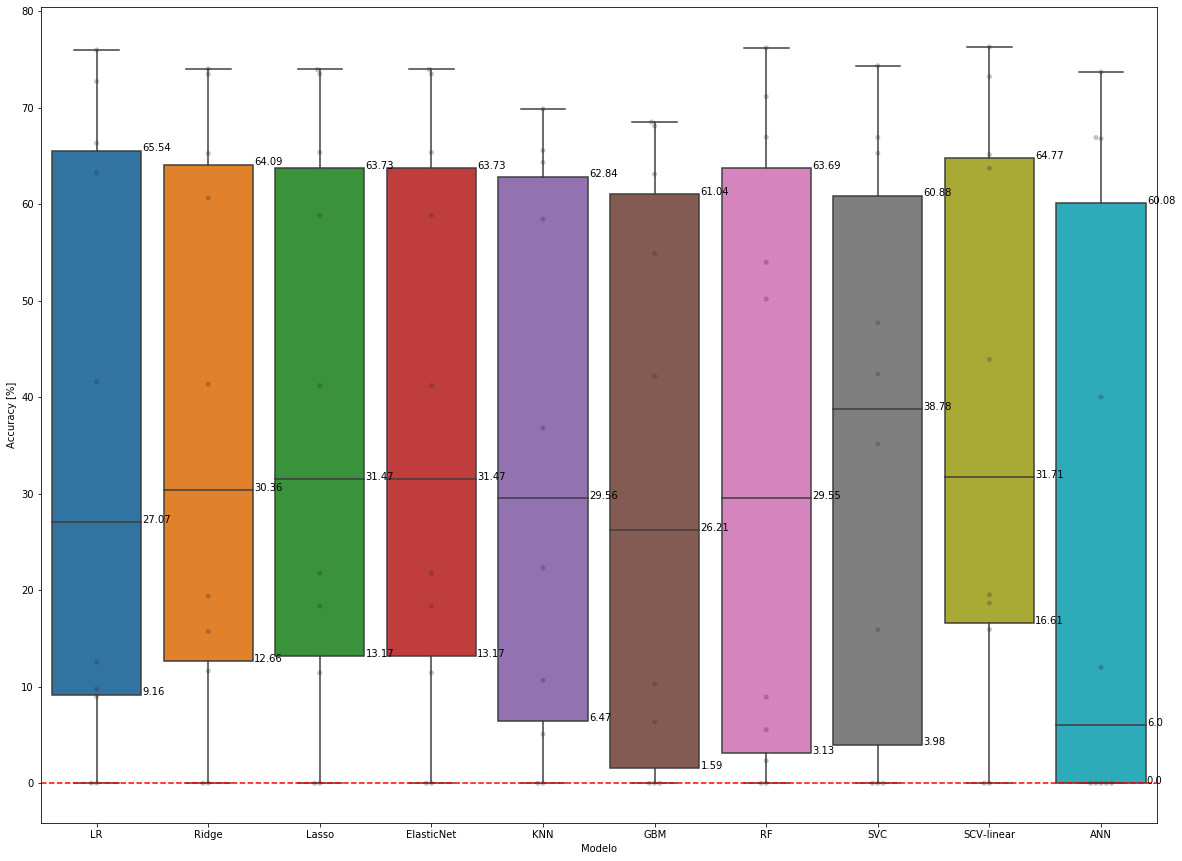

In [13]:
plot_box(results.loc[(results.Set == 'test') & (results.Model!='CART')], 'ACC','Model', 'Accuracy [%]', 'Modelo')
plt.axhline(y= acc_base, color='r', linestyle='--')
plt.savefig("reports/algorithms/acc_all.png".format(prod))

# Resultados

## Mean Absolute Error

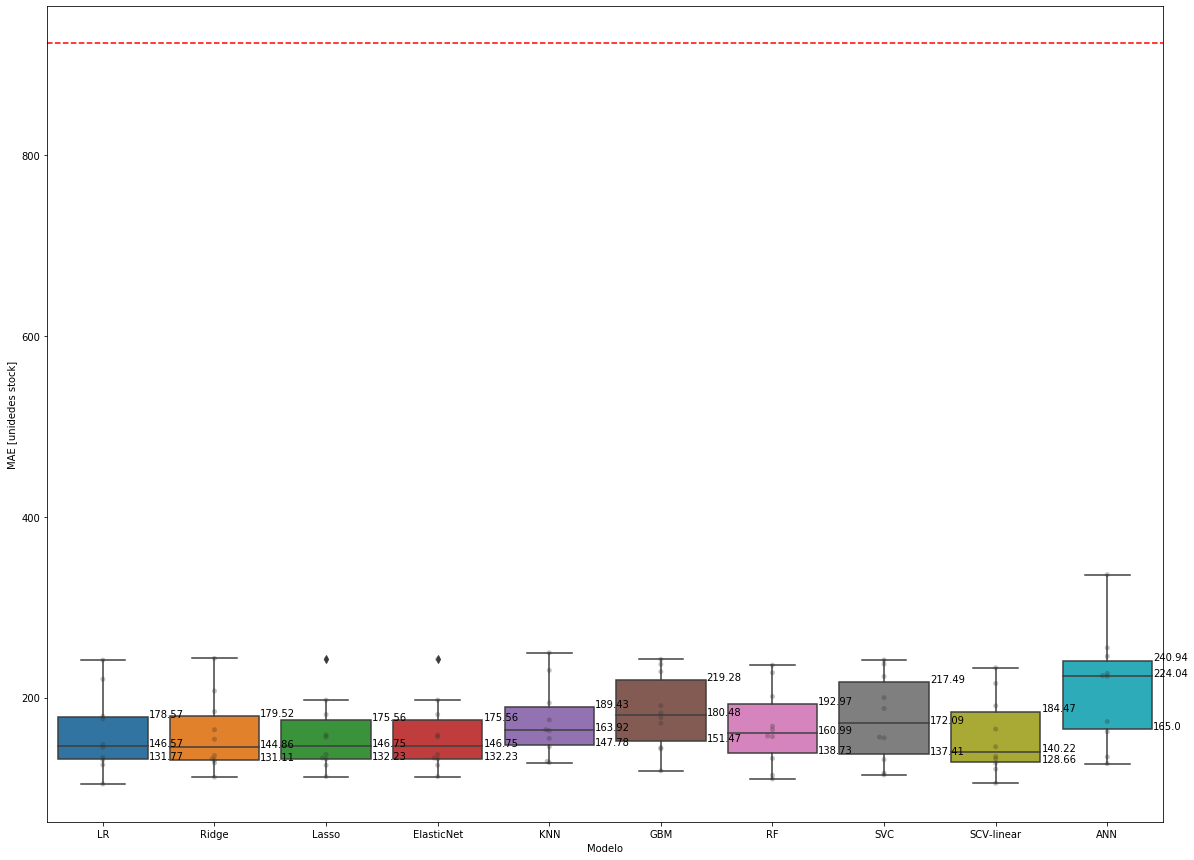

In [14]:
plot_box(results.loc[results.Set == 'test'], 'MAE','Model', 'MAE [unidedes stock]', 'Modelo')

plt.axhline(y= mae_base, color='r', linestyle='--')
plt.savefig("reports/algorithms/mae_{}.png".format(prod))

## Root of Mean Squeared Error

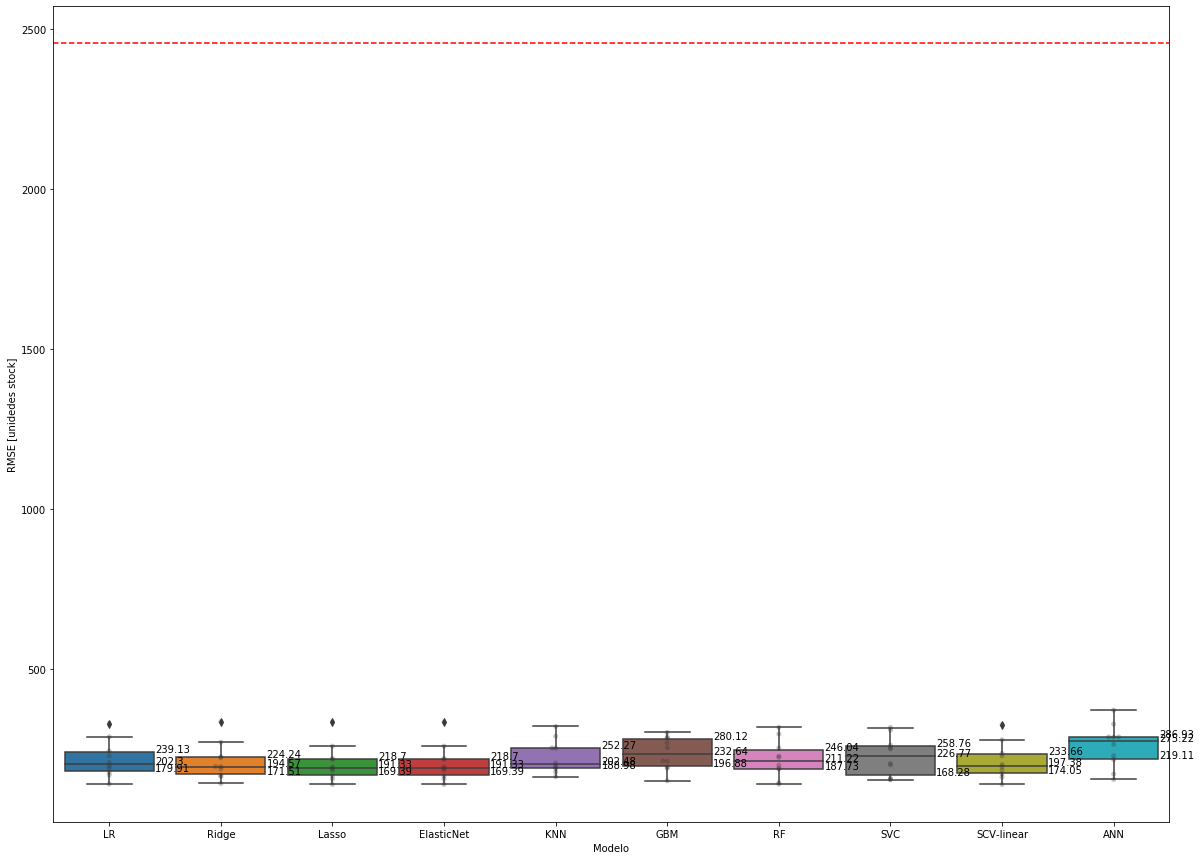

In [15]:
plot_box(results.loc[results.Set == 'test'], 'RMSE','Model', 'RMSE [unidedes stock]', 'Modelo')
plt.axhline(y= rmse_base, color='r', linestyle='--')
plt.savefig("reports/algorithms/rmse_{}.png".format(prod))

## Accuracy

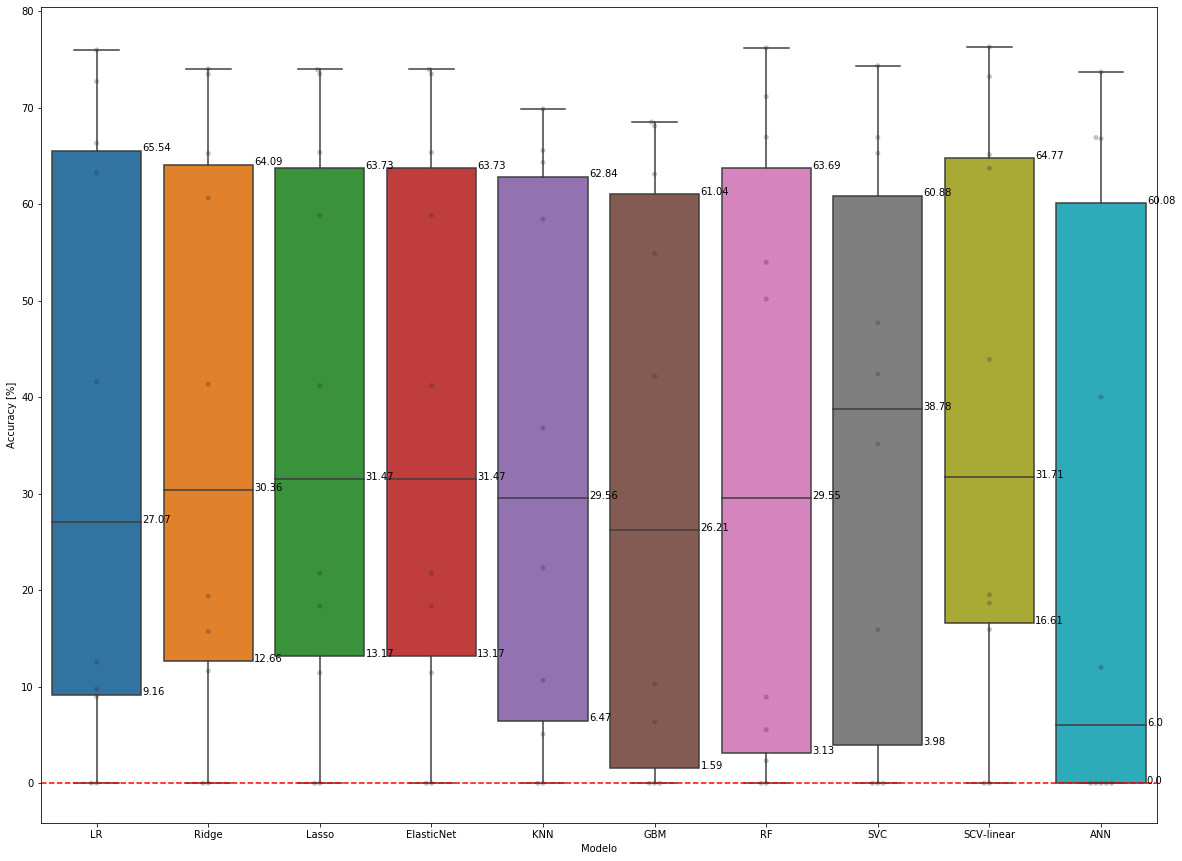

In [16]:
plot_box(results.loc[(results.Set == 'test') & (results.Model!='CART')], 'ACC','Model', 'Accuracy [%]', 'Modelo')
plt.axhline(y= acc_base, color='r', linestyle='--')
plt.savefig("reports/algorithms/acc_{}.png".format(prod))

# A model at a time

In [17]:
full_data = pd.DataFrame({})
for prod in ["48"]:
    data = main_df.loc[main_df.stockMissingType == 0].reset_index(drop=True)
    data = data.loc[data.producto == prod]
    data = prepare_train_data(data)
    data = data[['udsstock', 'roll4wd_udsprevisionempresa',
                                            'working_day', 'month', "quarter","weekofyear",
                                           'summer', 'autumn', 'winter',"cos_weekday","sin_weekday",
                                           'udsprevisionempresa_shifted-1','udsprevisionempresa_shifted-6',
                                            'udsstock_shifted7', 'roll4wd_udsstock_shifted7'
                                           ]]
    train, test = train_test_split(data, test_size=0.1, shuffle=False)
    full_data = pd.concat([full_data, train]).reset_index(drop=True)

===================  FILTER TRAIN DATA  ====================
Dropped rows corresponding to 23 to 26-03-2020 for not having the ventas data for these days.
Rows dropped: 4
Assigned missings in udsventa.
Assigned missings in udsprevisionempresa filling with 0
Assigning missings for udsstock
Missing in dataset:               0 (199 total rows).
Missings in holiday days:         0 (28 total rows).
Missings in working days:         0 (171 total rows).
Assigned missings for working days data with the 4last wd rolling window - Remaining missings: 0
Assigned left missings for working days data with the mean of the weekday - Remaining missings: 0
Assigned missings for holiday data and no active business data - Remaining missings:      0
Get shifted variable for udsprevisionempresa with period -1
Get shifted variable for udsprevisionempresa with period -2
Get shifted variable for udsprevisionempresa with period -3
Get shifted variable for udsprevisionempresa with period -4
Get shifted variable f

In [18]:
full_data

,udsstock,roll4wd_udsprevisionempresa,working_day,month,quarter,weekofyear,summer,autumn,winter,cos_weekday,sin_weekday,udsprevisionempresa_shifted-1,udsprevisionempresa_shifted-6,udsstock_shifted7,roll4wd_udsstock_shifted7
0,494.0,11678.000,True,6,2,23,1,0,0,-0.222521,0.974928,3498.0,0.0,0.0,0.000000
1,882.0,3498.000,True,6,2,24,1,0,0,0.623490,0.781831,1594.0,2825.0,0.0,0.000000
2,1366.0,9157.000,True,6,2,24,1,0,0,-0.222521,0.974928,2599.0,3199.0,0.0,0.000000
3,1560.0,12121.750,True,6,2,24,1,0,0,-0.900969,0.433884,3914.0,4535.0,0.0,0.000000
4,843.0,10357.250,True,6,2,24,1,0,0,-0.900969,-0.433884,1284.0,5238.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174,1201.0,1703.750,True,2,1,7,0,0,1,1.000000,0.000000,2355.0,2810.0,697.0,672.571429
175,794.0,1628.000,True,2,1,7,0,0,1,0.623490,0.781831,4535.0,3940.0,552.0,1308.000000
176,1124.0,2652.750,True,2,1,7,0,0,1,-0.222521,0.974928,5382.0,2149.0,736.0,1763.400000
177,2190.0,2497.625,True,2,1,7,0,0,1,-0.900969,0.433884,9470.0,1635.0,998.0,1718.250000


In [19]:
cols = full_data.columns

scaler = MinMaxScaler()
X = scaler.fit_transform(full_data)
X = pd.DataFrame(data=X, columns = cols)
X

,udsstock,roll4wd_udsprevisionempresa,working_day,month,quarter,weekofyear,summer,autumn,winter,cos_weekday,sin_weekday,udsprevisionempresa_shifted-1,udsprevisionempresa_shifted-6,udsstock_shifted7,roll4wd_udsstock_shifted7
0,0.184423,0.963392,1.0,0.454545,0.333333,0.431373,1.0,0.0,0.0,3.568959e-01,1.000000,0.369377,0.000000,0.000000,0.000000
1,0.358102,0.288572,1.0,0.454545,0.333333,0.450980,1.0,0.0,0.0,8.019377e-01,0.900969,0.168321,0.298310,0.000000,0.000000
2,0.574754,0.755419,1.0,0.454545,0.333333,0.450980,1.0,0.0,0.0,3.568959e-01,1.000000,0.274446,0.337804,0.000000,0.000000
3,0.661594,1.000000,1.0,0.454545,0.333333,0.450980,1.0,0.0,0.0,5.551115e-17,0.722521,0.413305,0.478881,0.000000,0.000000
4,0.340645,0.854435,1.0,0.454545,0.333333,0.450980,1.0,0.0,0.0,0.000000e+00,0.277479,0.135586,0.553115,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174,0.500895,0.140553,1.0,0.090909,0.000000,0.117647,0.0,0.0,1.0,1.000000e+00,0.500000,0.248680,0.296727,0.300950,0.381406
175,0.318711,0.134304,1.0,0.090909,0.000000,0.117647,0.0,0.0,1.0,8.019377e-01,0.900969,0.478881,0.416051,0.238342,0.741749
176,0.466428,0.218842,1.0,0.090909,0.000000,0.117647,0.0,0.0,1.0,3.568959e-01,1.000000,0.568321,0.226927,0.317789,1.000000
177,0.943599,0.206045,1.0,0.090909,0.000000,0.117647,0.0,0.0,1.0,5.551115e-17,0.722521,1.000000,0.172650,0.430915,0.974396


In [20]:
reals = []
preds = []

for idx in range(100,179,1):
    df_train = X.iloc[:idx]
    df_test = X.iloc[idx:idx+1]
    # Convertimos features y target en numpies
    X_train = np.array(df_train.drop(columns=[target], axis=1))
    X_test = np.array(df_test.drop(columns=[target], axis=1))
    y_train = np.array(df_train[target])
    y_test = np.array(df_test[target])
    
    # Entrenamos
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Predecimos
    # y_pred_train = model.predict(X_train)
    y_pred = model.predict(X_test)
    
    reals.append(y_test[0])
    preds.append(y_pred[0])

In [21]:
get_error(np.array(reals).reshape(-1), np.array(preds).reshape(-1))

[0.1627612346534141, 0.20931529452910522, 55.15098003594223, 44.84901996405777]

# RNN and RF

In [22]:
full_data = pd.DataFrame({})
for prod in ["48"]:
    data = main_df.loc[main_df.stockMissingType == 0].reset_index(drop=True)
    data = data.loc[data.producto == prod]
    data = prepare_train_data(data)
    data.index = data.fecha
    data = data[['udsstock', 'roll4wd_udsprevisionempresa',
                                            'working_day', 'month', "quarter","weekofyear",
                                           'summer', 'autumn', 'winter',"cos_weekday","sin_weekday",
                                           'udsprevisionempresa_shifted-1','udsprevisionempresa_shifted-6',
                                            'udsstock_shifted7', 'roll4wd_udsstock_shifted7'
                                           ]]
    train, test = train_test_split(data, test_size=0.1, shuffle=False)
    full_data = pd.concat([full_data, train]).reset_index(drop=True)

===================  FILTER TRAIN DATA  ====================
Dropped rows corresponding to 23 to 26-03-2020 for not having the ventas data for these days.
Rows dropped: 4
Assigned missings in udsventa.
Assigned missings in udsprevisionempresa filling with 0
Assigning missings for udsstock
Missing in dataset:               0 (199 total rows).
Missings in holiday days:         0 (28 total rows).
Missings in working days:         0 (171 total rows).
Assigned missings for working days data with the 4last wd rolling window - Remaining missings: 0
Assigned left missings for working days data with the mean of the weekday - Remaining missings: 0
Assigned missings for holiday data and no active business data - Remaining missings:      0
Get shifted variable for udsprevisionempresa with period -1
Get shifted variable for udsprevisionempresa with period -2
Get shifted variable for udsprevisionempresa with period -3
Get shifted variable for udsprevisionempresa with period -4
Get shifted variable f

In [23]:
from statsmodels.tsa.seasonal import seasonal_decompose

def plot_seasonal_descompose(serie, period):
    
    result = seasonal_decompose(serie, model='additive', period=period)
    
    plt.figure(figsize=(20,40))
    plt.subplot(4,1,1)
    result.observed.plot(title='Observed')
    plt.subplot(4,1,2)
    result.trend.plot(title='Trend')
    plt.subplot(4,1,3)
    result.seasonal.plot(title='Seasonal - Period {}'.format(period))
    plt.subplot(4,1,4)
    result.resid.plot(title='Residual')
    plt.tight_layout()

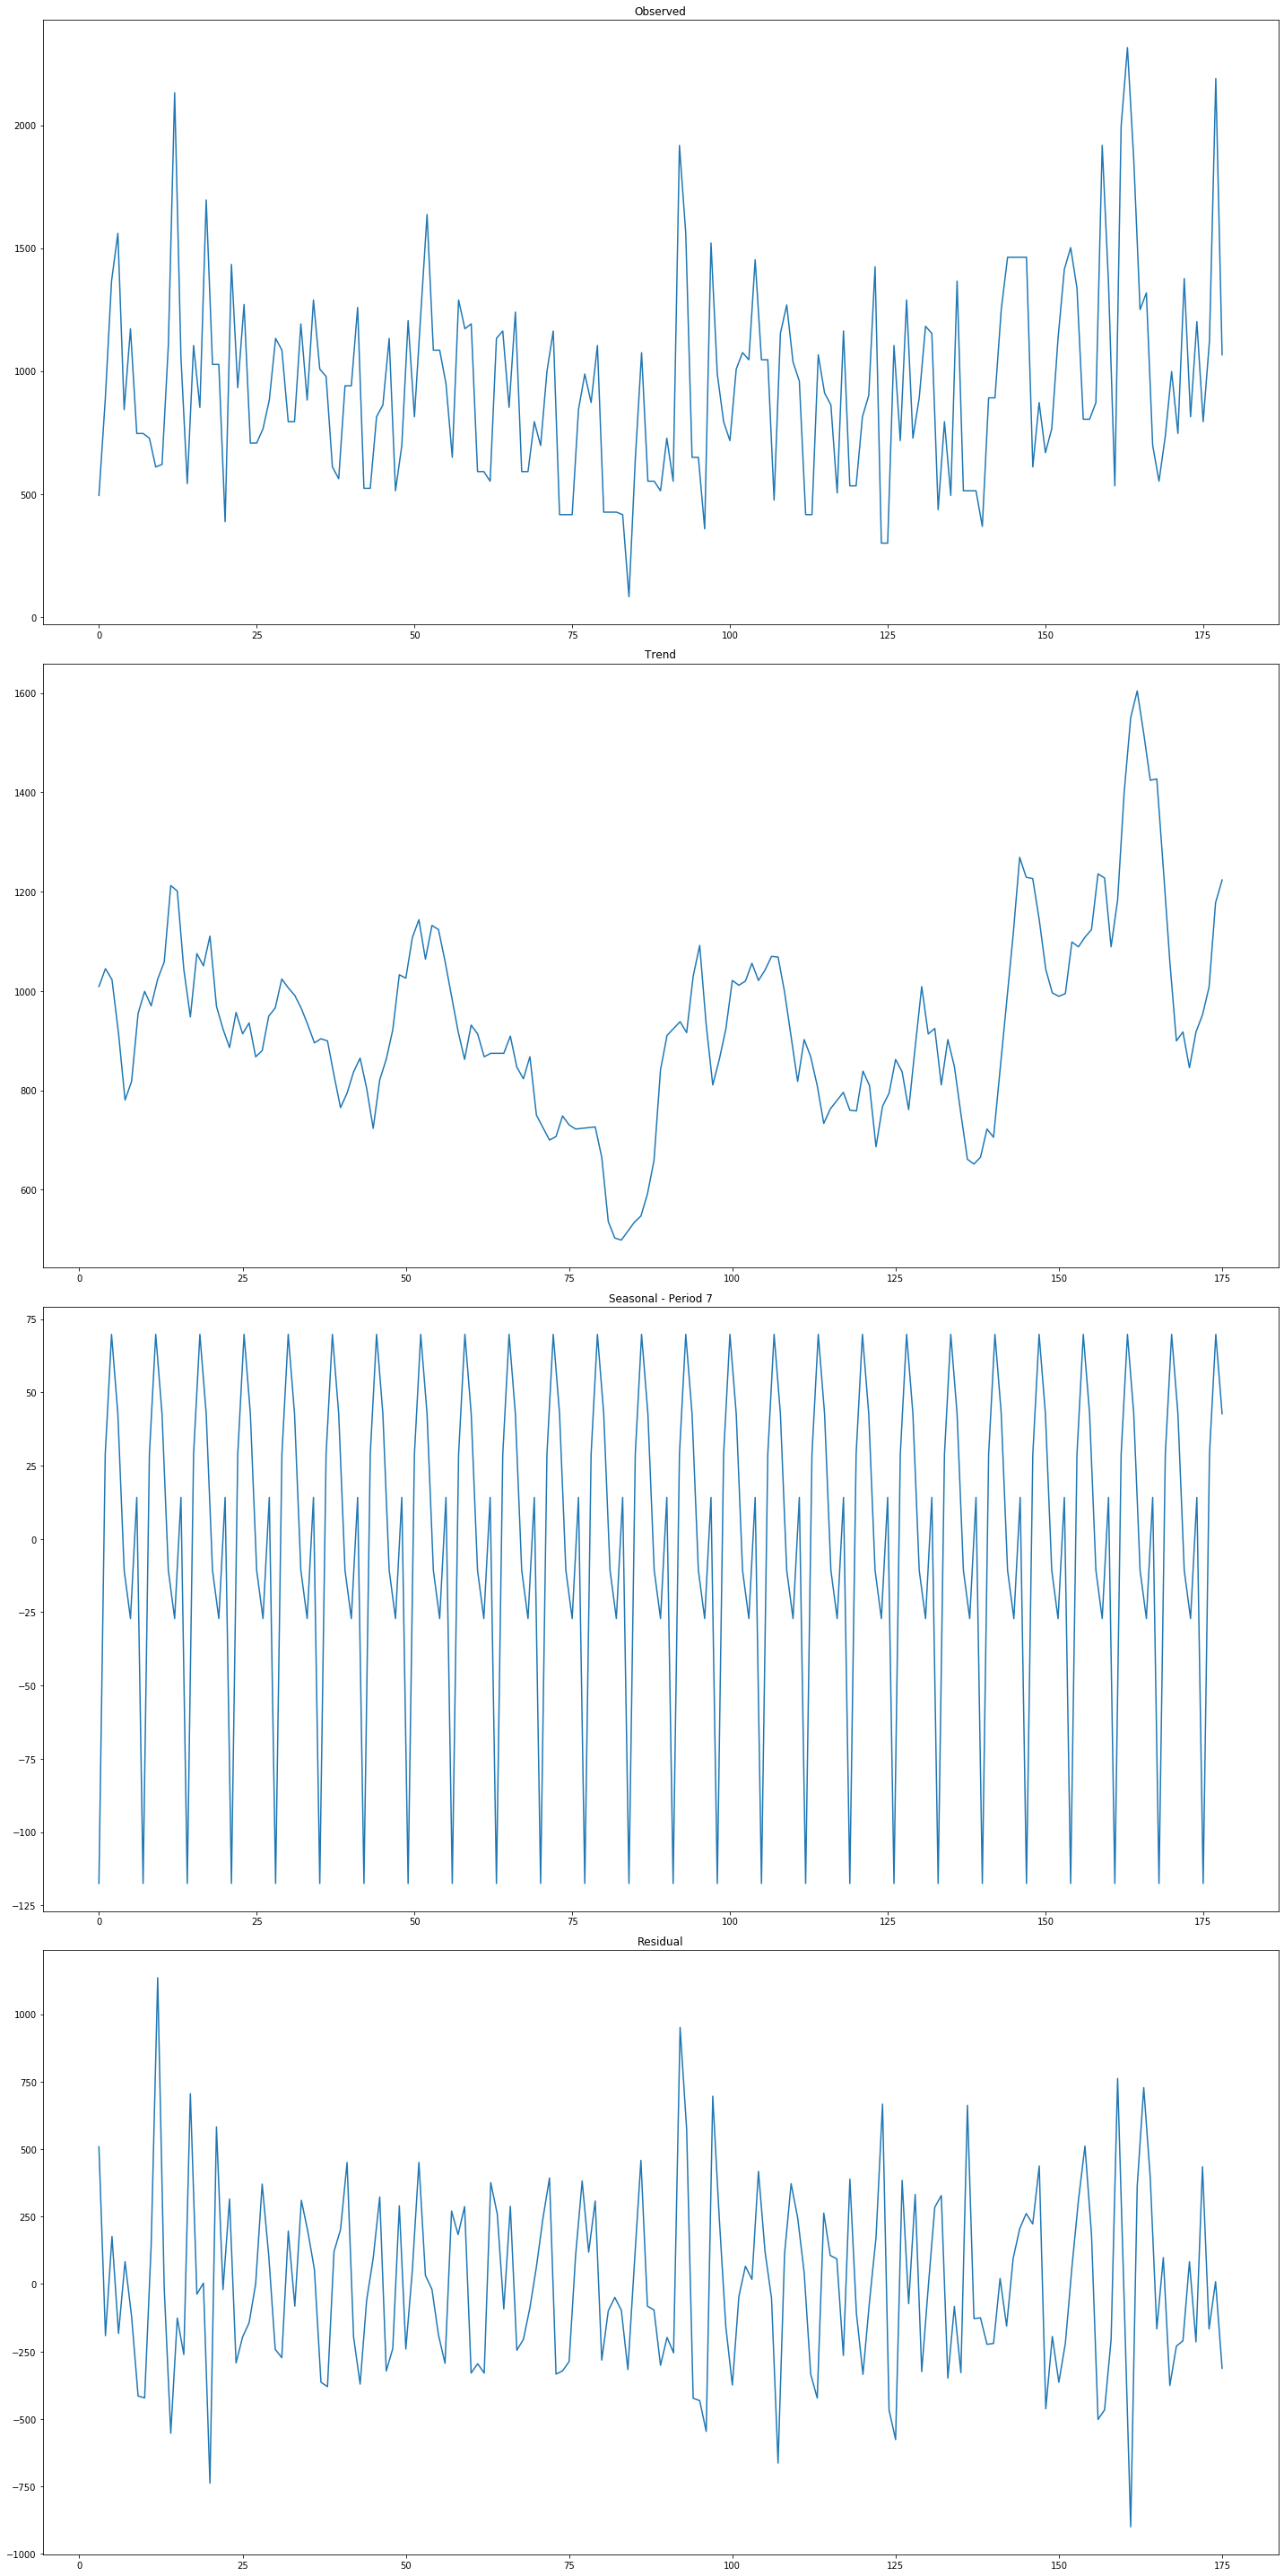

In [24]:
plot_seasonal_descompose(full_data.udsstock, 7)

# Modelos finales

In [25]:
metrics = pd.read_csv("metrics.csv")

metrics

,mape_mean,mape_std,rmse_mean,rmse_std,mae_mean,mae_std,mean_error_mean,mean_error_std,std_error_mean,std_error_std,smape_mean,smape_std,mase_mean,mase_std,mase_wd_mean,mase_wd_std,features,modelo,type
0,236.259778,57.319087,1315.069564,68.062487,490.250725,11.937707,-18.153810,28.310966,1314.640314,68.045803,34.520650,0.067300,0.472772,0.036431,0.011206,0.001329,18,ALL,ALL
1,215.888615,142.210078,613.982554,91.960782,350.496514,40.199374,5.046576,29.777169,613.145626,92.583231,34.021210,2.741285,0.524774,0.037654,0.013711,0.001705,18,CL_1,CL
2,130.567211,83.727185,836.965473,71.185061,619.421774,53.786666,-32.780978,81.336835,832.215756,72.836653,32.411741,3.094344,0.550597,0.030169,0.013737,0.001940,18,CL_2,CL
3,140.190715,40.735823,288.626916,19.924529,137.655822,7.105396,1.562236,16.494977,288.139091,20.095345,45.275218,2.254386,0.515218,0.030167,0.011156,0.000898,18,CL_3,CL
4,128.329699,53.184525,257.427822,7.438196,185.867691,2.806510,-2.058571,18.705517,256.750567,7.030104,30.770487,0.372203,0.525979,0.020306,0.012769,0.000397,18,CL_4,CL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74,217.019178,115.407360,128.471485,31.053327,70.985357,12.903795,-4.189025,33.149428,123.629944,32.686942,63.388433,8.865387,0.633923,0.282822,0.016945,0.012826,18,PR_91,PR
75,71.916673,67.147402,240.787935,46.984219,175.683331,35.102510,-6.183157,35.975419,237.388117,50.007660,29.056621,6.113633,0.535672,0.073231,0.013423,0.003200,18,PR_94,PR
76,952.670266,659.844224,240.801853,16.064206,189.616411,16.839666,-13.335848,36.958588,237.635896,15.132415,45.557378,7.296511,0.505919,0.039464,0.015123,0.001286,18,PR_96,PR
77,369.703164,411.149552,179.126619,42.357369,132.683785,30.313456,-0.988970,35.189938,175.871811,41.355638,45.098784,4.591440,0.612149,0.118868,0.014060,0.002667,18,PR_97,PR


In [26]:
metrics.loc[metrics.type == "PR"]

,mape_mean,mape_std,rmse_mean,rmse_std,mae_mean,mae_std,mean_error_mean,mean_error_std,std_error_mean,std_error_std,smape_mean,smape_std,mase_mean,mase_std,mase_wd_mean,mase_wd_std,features,modelo,type
11,195.019857,165.203305,7953.065921,1328.929024,4910.686447,843.524944,-63.580985,2001.099523,7701.363444,1303.023081,51.896578,6.540964,0.497527,0.158134,0.010437,0.003649,18,PR_1,PR
12,174.776106,121.999794,876.804133,144.895608,651.940000,92.053440,-38.003827,97.109858,870.906897,142.922313,40.356672,7.274507,0.607683,0.075615,0.014015,0.002685,18,PR_10,PR
13,150.708661,102.263969,3786.488885,1195.254398,2168.653650,340.531910,-69.874985,714.564611,3723.465149,1177.477532,47.783039,6.183088,0.773911,0.214973,0.018687,0.006124,18,PR_11,PR
14,58.483403,8.981948,900.232153,179.984487,626.548278,106.537042,-21.290909,116.793864,892.926506,177.201833,36.781724,7.133181,0.715394,0.184893,0.018109,0.005717,18,PR_12,PR
15,235.192995,246.884251,951.916384,122.494131,736.430228,115.548951,-18.009727,185.280821,933.878562,119.862890,29.901601,7.022118,0.521325,0.069804,0.013850,0.004609,18,PR_13,PR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74,217.019178,115.407360,128.471485,31.053327,70.985357,12.903795,-4.189025,33.149428,123.629944,32.686942,63.388433,8.865387,0.633923,0.282822,0.016945,0.012826,18,PR_91,PR
75,71.916673,67.147402,240.787935,46.984219,175.683331,35.102510,-6.183157,35.975419,237.388117,50.007660,29.056621,6.113633,0.535672,0.073231,0.013423,0.003200,18,PR_94,PR
76,952.670266,659.844224,240.801853,16.064206,189.616411,16.839666,-13.335848,36.958588,237.635896,15.132415,45.557378,7.296511,0.505919,0.039464,0.015123,0.001286,18,PR_96,PR
77,369.703164,411.149552,179.126619,42.357369,132.683785,30.313456,-0.988970,35.189938,175.871811,41.355638,45.098784,4.591440,0.612149,0.118868,0.014060,0.002667,18,PR_97,PR


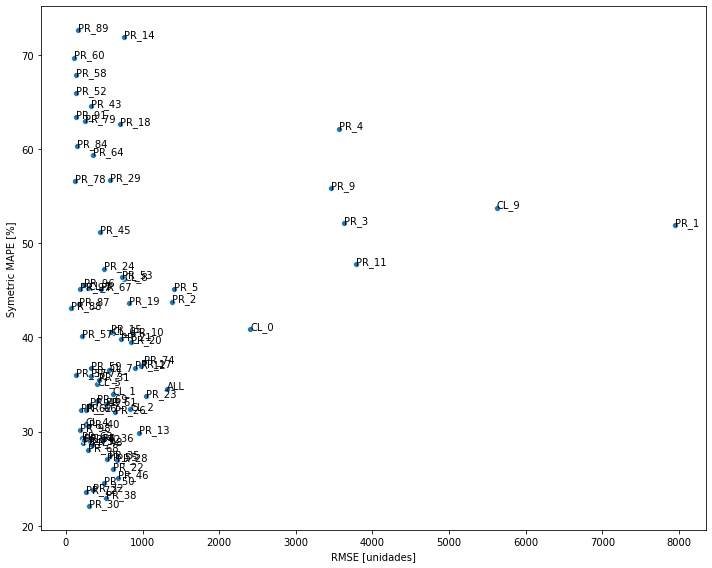

In [27]:
plt.figure(figsize=(10,8))
sns.scatterplot(x="rmse_mean", y="smape_mean", data=metrics)
for idx in metrics.index:
    x = metrics.loc[idx, "rmse_mean"]
    y = metrics.loc[idx, "smape_mean"]
    label = metrics.loc[idx, "modelo"]
    plt.text(x+0.2, y, label )
plt.tight_layout()
plt.ylabel("Symetric MAPE [%]")
plt.xlabel("RMSE [unidades]")
plt.savefig("reports/final_models.png")    

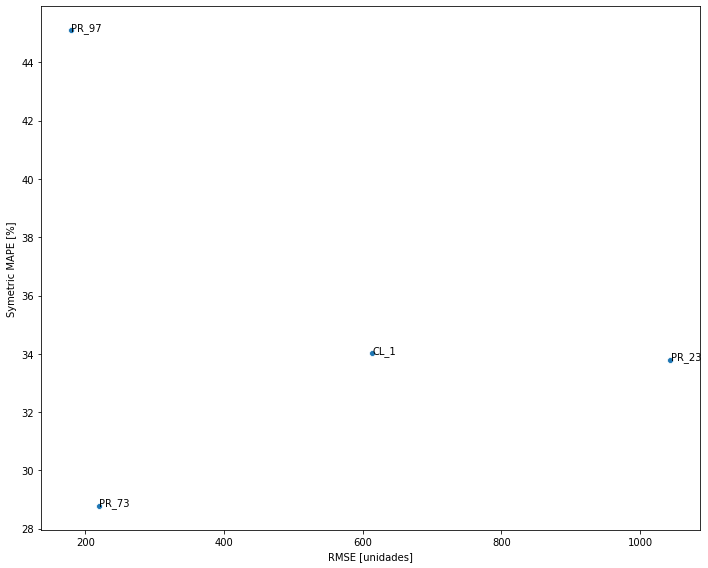

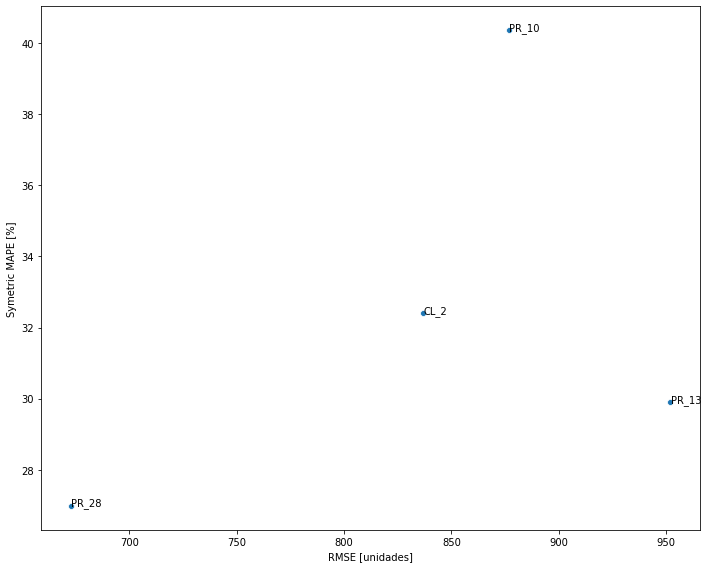

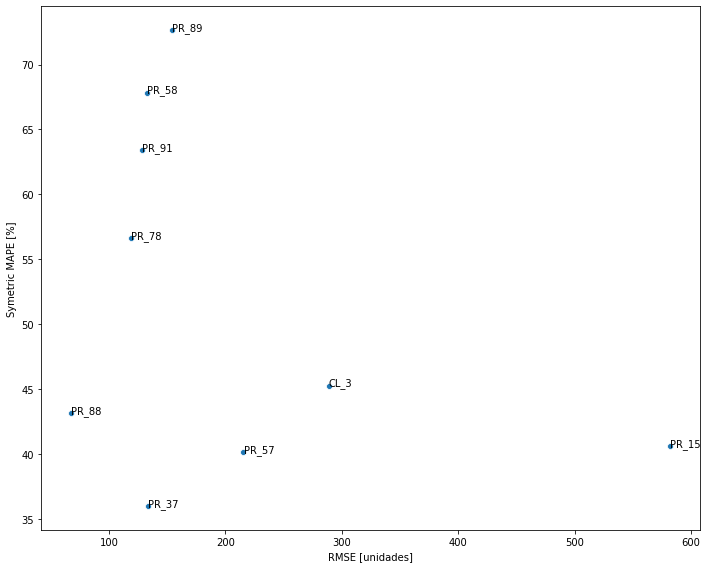

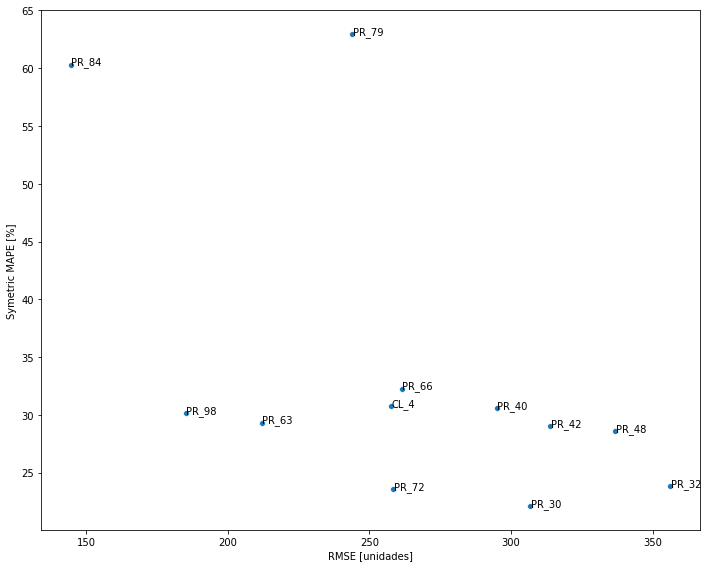

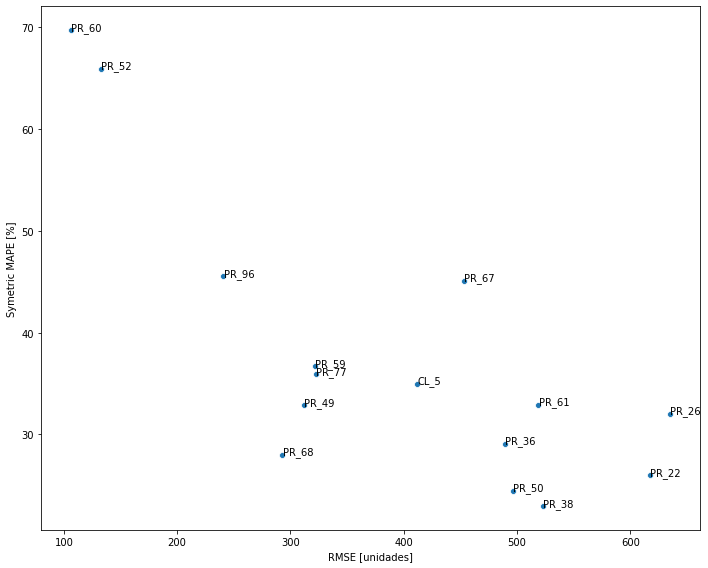

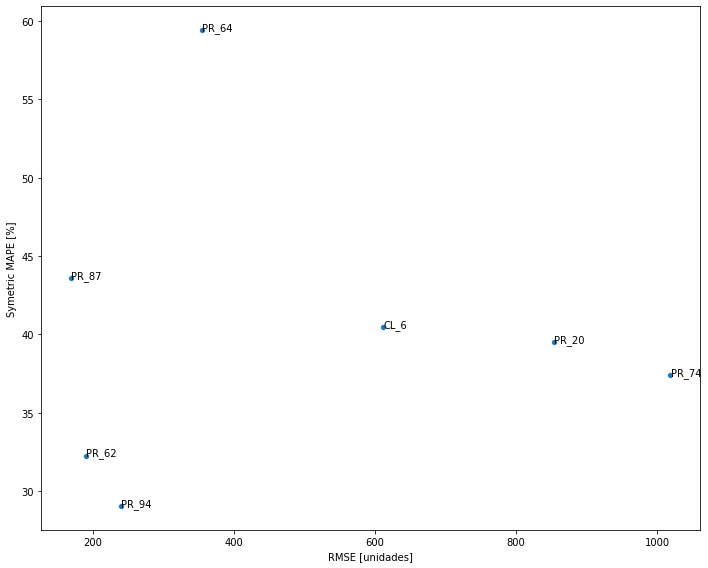

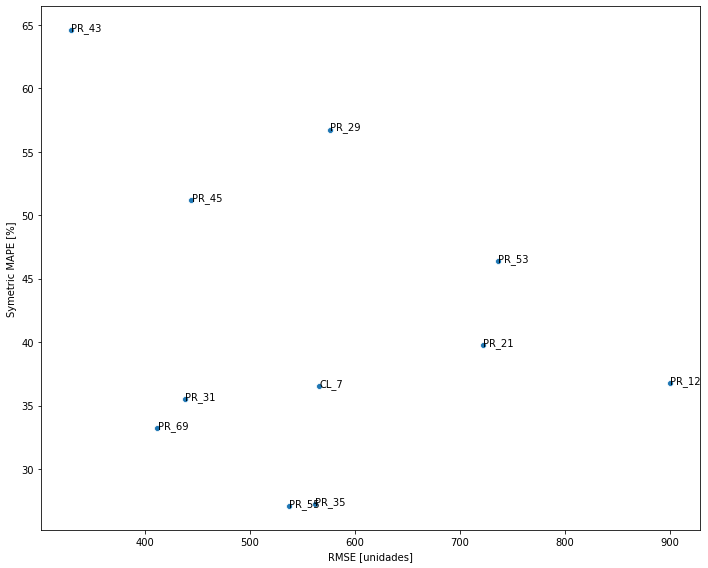

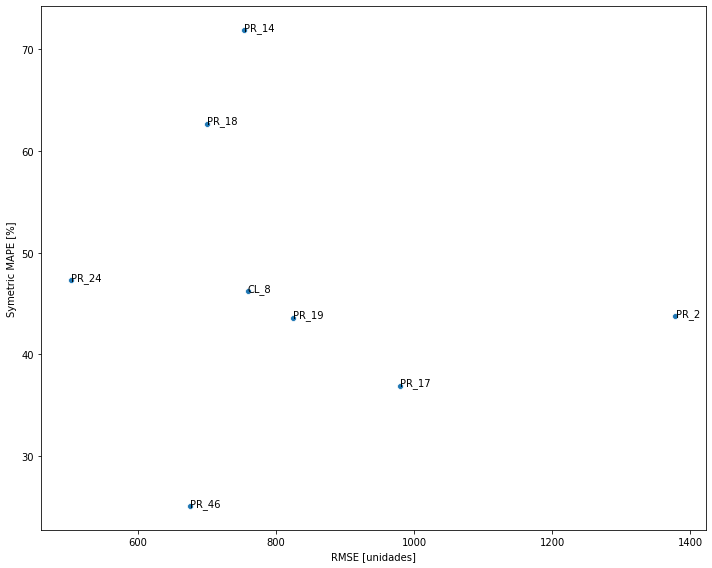

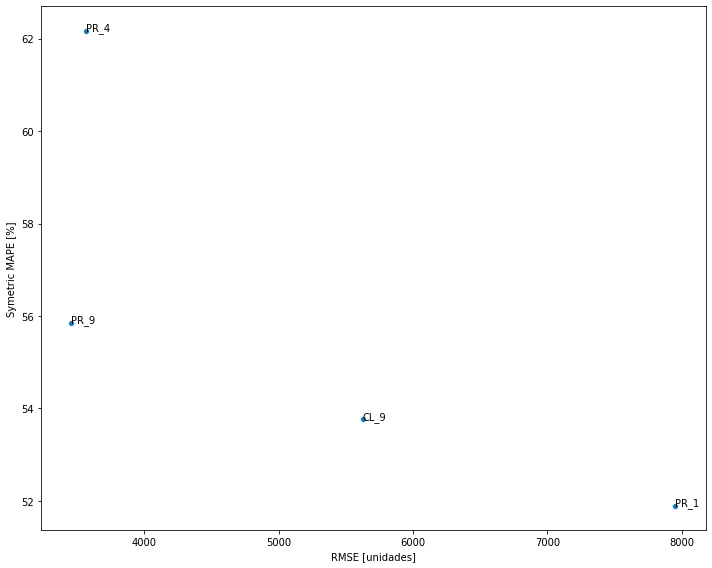

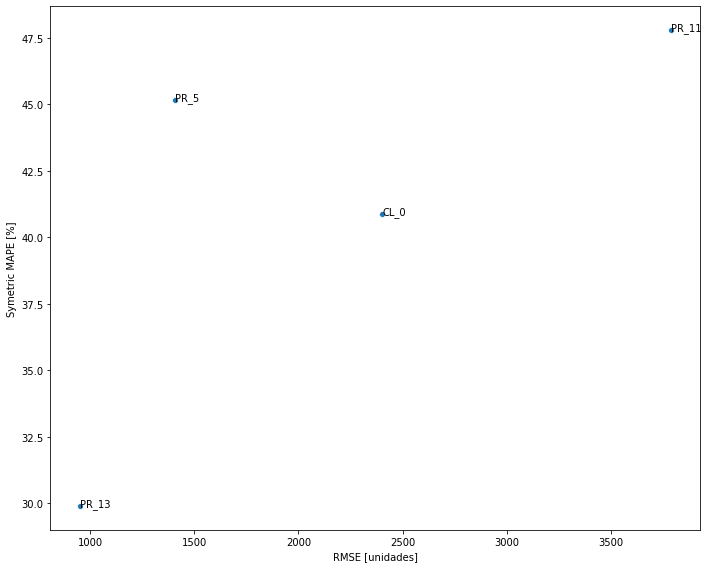

In [28]:
import json
with open("config/model_stock.json") as config_file: 
    config = json.load(config_file)
    
for modelo in list(config):
    selected = [modelo]
    if modelo[:2] == "CL":
        prods = ["PR_" + x for x in config[modelo]["productos"]]
        selected += prods
        data = metrics.loc[metrics.modelo.isin(selected)].reset_index(drop=True)
        plt.figure(figsize=(10,8))
        sns.scatterplot(x="rmse_mean", y="smape_mean", data=data)
        for idx in data.index:
            x = data.loc[idx, "rmse_mean"]
            y = data.loc[idx, "smape_mean"]
            label = data.loc[idx, "modelo"]
            plt.text(x+0.2, y, label )
        plt.tight_layout()
        plt.ylabel("Symetric MAPE [%]")
        plt.xlabel("RMSE [unidades]")
        plt.savefig("reports/final_models_{}.png".format(modelo))   

# Predictions

In [32]:
preds = pd.read_csv("predict.csv", parse_dates=["fecha"], dtype={"producto":str})
preds

,y_pred,y_real,type,fecha,producto,modelo
0,17460.670,18275.0,train,2019-06-05,1,ALL
1,3553.240,2920.0,train,2019-06-11,1,ALL
2,6558.955,6731.0,train,2019-06-12,1,ALL
3,7922.845,7241.0,train,2019-06-13,1,ALL
4,4757.160,3850.0,train,2019-06-14,1,ALL
...,...,...,...,...,...,...
32603,245.255,3.0,test,2020-03-17,98,PR_98
32604,317.745,90.0,test,2020-03-18,98,PR_98
32605,509.055,714.0,test,2020-03-19,98,PR_98
32606,578.395,786.0,test,2020-03-20,98,PR_98


In [30]:
from src.load_data import load_csv
df = load_csv("stock")
df = df.groupby(["producto","fecha"])['udsstock'].agg(['min',"mean", 'max']).reset_index()
df.columns = ["producto","fecha","stockmin","stockmean","stockmax"]
preds = preds.merge(df, on=["fecha","producto"]).set_index("fecha")
ventas = load_csv("ventas")

preds = preds.merge(ventas, on=["fecha","producto"]).set_index("fecha")
preds

===================  LOAD DATASET stock ====================
Reading CSV in data/raw/03_TablaStock.csv...
=============  CLEAN CSV  ==============
Set columns to lowcase.
Sort values by date.
Dropped duplicates. Rows dropped: 628.
============  CLEAN STOCK  =============
Dropped rows with data from products with no stock data or out-of-date (descatalogados). Rows dropped: 1764
[WARNING] Number of dates missings:                                83
[WARNING] Number of dates missings (droping sundays and festivos): 63
[WARNING] Stock data with different units for same product & data. Rows: 12679
Dataset stock loaded. Shape: (25538, 3)

===================  LOAD DATASET ventas ===================
Reading CSV in data/raw/01_TablaVentas.csv...
=============  CLEAN CSV  ==============
Set columns to lowcase.
Sort values by date.
Dropped duplicates. Rows dropped: 0.
============  CLEAN VENTAS  ============
Dropped rows with data from products with no stock data or out-of-date (descatalogados). 

,y_pred,y_real,type,producto,modelo,stockmin,stockmean,stockmax,udsventa
fecha,,,,,,,,,
2019-06-05,17460.670,18275.0,train,1,ALL,13919.0,18275.5,22632.0,2833
2019-06-05,14752.125,18275.0,train,1,CL_9,13919.0,18275.5,22632.0,2833
2019-06-05,15025.280,18275.0,train,1,PR_1,13919.0,18275.5,22632.0,2833
2019-06-11,3553.240,2920.0,train,1,ALL,2224.0,2920.0,3616.0,1416
2019-06-11,3860.660,2920.0,train,1,CL_9,2224.0,2920.0,3616.0,1416
...,...,...,...,...,...,...,...,...,...
2020-01-16,2074.330,2329.0,train,16,CL_7,1774.0,2329.0,2884.0,5038
2020-01-17,924.150,754.0,train,16,CL_7,574.0,754.0,934.0,3134
2020-01-20,115.115,71.0,train,16,CL_7,54.0,71.0,88.0,1613


# Validación

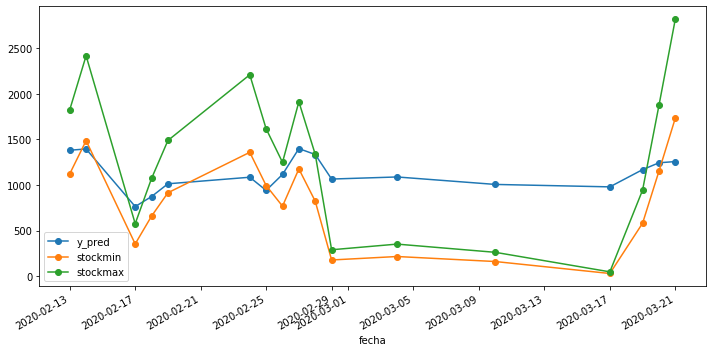

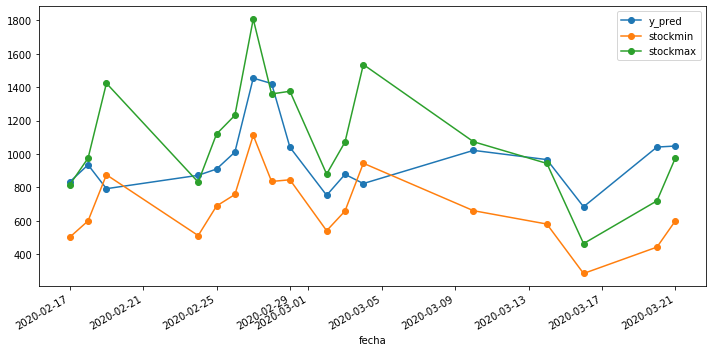

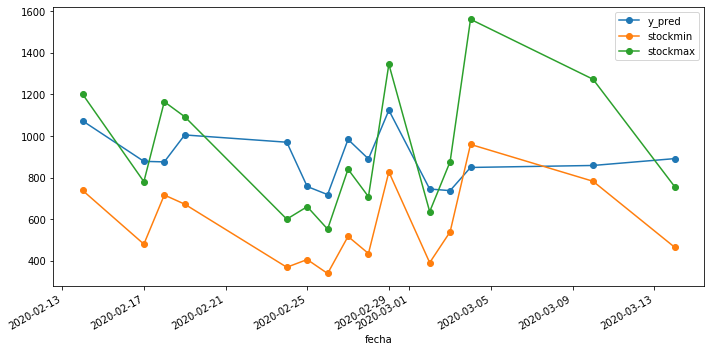

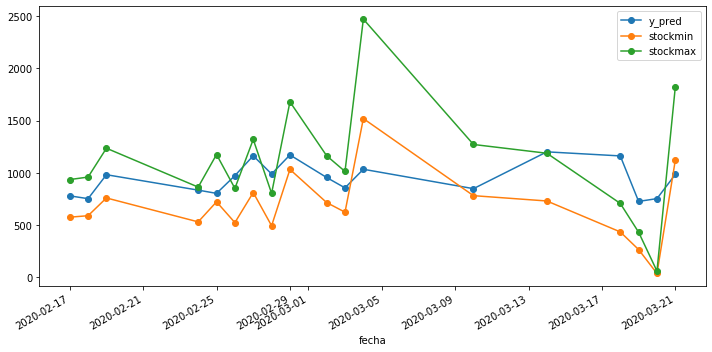

In [31]:
for modelo in ["PR_30","PR_32","PR_42","PR_48"]:
    preds.loc[(preds.type == "test") & (preds.modelo == modelo), ["y_pred", "stockmin","stockmax"]].plot(figsize=(10,5), marker="o")
    plt.tight_layout()
    plt.savefig("validation_{}.png".format(modelo))

# Roturas de stock

In [24]:
def get_stat(serie):
    num_roturas = (serie.balance_real < 0).sum()
    num_roturas_pred = (serie.balance_pred < 0).sum()
    
    sobrestock_medio = serie.loc[serie.balance_real > 0].balance_real.median()
    sobrestock_medio_pred = serie.loc[serie.balance_pred > 0].balance_pred.median()
    
    return num_roturas, num_roturas_pred, sobrestock_medio, sobrestock_medio_pred

In [25]:
preds["balance_real"] = preds["y_real"] - preds["udsventa"]
preds["balance_pred"] = preds["y_pred"] - preds["udsventa"]

preds

,y_pred,y_real,type,producto,modelo,stockmin,stockmean,stockmax,udsventa,balance_real,balance_pred
fecha,,,,,,,,,,,
2019-06-05,17460.670,18275.0,train,1,ALL,13919.0,18275.5,22632.0,2833,15442.0,14627.670
2019-06-05,14752.125,18275.0,train,1,CL_9,13919.0,18275.5,22632.0,2833,15442.0,11919.125
2019-06-05,15025.280,18275.0,train,1,PR_1,13919.0,18275.5,22632.0,2833,15442.0,12192.280
2019-06-11,3553.240,2920.0,train,1,ALL,2224.0,2920.0,3616.0,1416,1504.0,2137.240
2019-06-11,3860.660,2920.0,train,1,CL_9,2224.0,2920.0,3616.0,1416,1504.0,2444.660
...,...,...,...,...,...,...,...,...,...,...,...
2020-01-16,2074.330,2329.0,train,16,CL_7,1774.0,2329.0,2884.0,5038,-2709.0,-2963.670
2020-01-17,924.150,754.0,train,16,CL_7,574.0,754.0,934.0,3134,-2380.0,-2209.850
2020-01-20,115.115,71.0,train,16,CL_7,54.0,71.0,88.0,1613,-1542.0,-1497.885


In [33]:
cluster = ["CL_" + str(x) for x in range(10)]

rot = []
rot_pred = []
stock = []
stock_pred = []

for cl in cluster:
    serie = preds.loc[preds.modelo == cl]
    roturas, roturas_pred, sobrestock, sobrestock_pred = get_stat(serie)
    rot.append(roturas)
    rot_pred.append(roturas_pred)
    stock.append(sobrestock)
    stock_pred.append(sobrestock_pred)

df = pd.DataFrame({"modelo":cluster,
                   "roturas_stock":rot,
                   "roturas_stock_pred":rot_pred,
                   "sobrestock":stock,
                   "sobrestock_pred":stock_pred})


df.to_csv("validacion_cluster.csv", index=False)
df

,modelo,roturas_stock,roturas_stock_pred,sobrestock,sobrestock_pred
0,CL_0,134,126,1859.0,1690.3900
1,CL_1,170,145,429.0,388.1850
2,CL_2,160,152,1057.0,1021.5200
3,CL_3,382,350,206.0,176.8400
4,CL_4,401,360,395.0,382.6750
5,CL_5,602,545,716.0,695.0650
6,CL_6,325,300,490.0,444.0450
7,CL_7,669,630,619.0,585.3900
8,CL_8,599,595,1022.5,918.2250
9,CL_9,206,188,3506.5,3046.0475


In [35]:
(df.roturas_stock - df.roturas_stock_pred).sum()

257

In [36]:
(df.sobrestock - df.sobrestock_pred).sum()

951.6175000000005

In [40]:


rot = []
rot_pred = []
stock = []
stock_pred = []
modelos = []
for mod in preds.modelo.unique():
    if mod[:2] == "PR":
        serie = preds.loc[preds.modelo == mod]
        roturas, roturas_pred, sobrestock, sobrestock_pred = get_stat(serie)
        rot.append(roturas)
        rot_pred.append(roturas_pred)
        stock.append(sobrestock)
        stock_pred.append(sobrestock_pred)
        modelos.append(mod)

df = pd.DataFrame({"modelo":modelos,
                   "roturas_stock":rot,
                   "roturas_stock_pred":rot_pred,
                   "sobrestock":stock,
                   "sobrestock_pred":stock_pred})

df.to_csv("validacion_monoprod.csv", index=False)
df

,modelo,roturas_stock,roturas_stock_pred,sobrestock,sobrestock_pred
0,PR_1,57,49,5859.0,4615.2200
1,PR_10,103,104,435.0,358.8000
2,PR_11,45,36,2432.0,2195.5400
3,PR_12,41,29,857.0,705.6200
4,PR_13,40,30,1303.0,1140.6500
...,...,...,...,...,...
61,PR_9,73,69,2005.5,1532.4300
62,PR_94,20,14,389.0,378.5600
63,PR_96,38,37,312.5,299.9650
64,PR_97,86,83,157.0,155.6600


In [41]:
(df.roturas_stock - df.roturas_stock_pred).sum()

287

In [42]:
(df.sobrestock - df.sobrestock_pred).sum()

6466.4925

In [45]:
df.loc[df.sobrestock < df.sobrestock_pred]

,modelo,roturas_stock,roturas_stock_pred,sobrestock,sobrestock_pred
11,PR_20,55,49,839.0,864.295
28,PR_40,25,25,456.0,464.385
30,PR_43,104,102,249.0,263.660
35,PR_5,49,54,3745.5,4356.660
57,PR_79,81,87,205.0,233.205


In [46]:
df2 = df.loc[df.sobrestock < df.sobrestock_pred]

(df2.sobrestock - df2.sobrestock_pred).sum()

-687.7049999999999